### Results

#### class_names = {7: "horse", 8: "ship", 9: "truck"}

#### 3 by 3

Targeted Attack Success Rate (Class 7): 8.98%

Targeted Attack Success Rate (Class 8): 10.14%

Targeted Attack Success Rate (Class 9): 10.79%

#### 5 by 5

Targeted Attack Success Rate (Class 7): 9.17%

Targeted Attack Success Rate (Class 8): 9.87%

Targeted Attack Success Rate (Class 9): 11.06%

#### 7 by 7

Targeted Attack Success Rate (Class 7): 9.60%

Targeted Attack Success Rate (Class 8): 10.01%

Targeted Attack Success Rate (Class 9): 10.37%

#### 16 by 16

Targeted Attack Success Rate (Class 7): 8.50%

Targeted Attack Success Rate (Class 8): 14.20%

Targeted Attack Success Rate (Class 9): 12.33%

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np


if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU: CUDA")
elif torch.backends.mps.is_available():  # Check if MPS (Apple GPU) is available
    device = torch.device("mps")
    print("Using Apple GPU: MPS")
else:
    device = torch.device("cpu")
    print("Using CPU")

Using Apple GPU: MPS


In [3]:
# Load and preprocess the CIFAR-10 dataset
transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

trainset = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform
)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2
)

testset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform
)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2
)

In [4]:
import torchvision.models as models

# Load pre-trained ResNet-18 model
model = models.resnet18(pretrained=True)

# Modify the final layer for CIFAR-10
num_classes = 10
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)


def train(model, trainloader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        scheduler.step()
        print(
            f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(trainloader):.4f}"
        )


def evaluate(model, testloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Accuracy: {100 * correct / total:.2f}%")


# Train the model
train(model, trainloader, criterion, optimizer, num_epochs=20)

# Evaluate the model
evaluate(model, testloader)

# Save the model
torch.save(model.state_dict(), "cifar_resnet18_pretrained_Jiwon.pth")

/Users/Lin/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/Lin/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/20], Loss: 1.0445
Epoch [2/20], Loss: 0.7162
Epoch [3/20], Loss: 0.6228
Epoch [4/20], Loss: 0.5723
Epoch [5/20], Loss: 0.5277
Epoch [6/20], Loss: 0.4933
Epoch [7/20], Loss: 0.4672
Epoch [8/20], Loss: 0.4480
Epoch [9/20], Loss: 0.4275
Epoch [10/20], Loss: 0.4114
Epoch [11/20], Loss: 0.4006
Epoch [12/20], Loss: 0.3835
Epoch [13/20], Loss: 0.3775
Epoch [14/20], Loss: 0.3657
Epoch [15/20], Loss: 0.3580
Epoch [16/20], Loss: 0.3510
Epoch [17/20], Loss: 0.3443
Epoch [18/20], Loss: 0.3340
Epoch [19/20], Loss: 0.3250
Epoch [20/20], Loss: 0.3249
Accuracy: 83.27%


In [5]:
def create_patch(patch_size=(3, 3)):
    patch = torch.randn(3, *patch_size, requires_grad=True, device=device)  # RGB
    return patch


def place_patch(img, patch):
    patch = patch.to(img.device)
    patched_img = img.clone()
    batch_size, _, h, w = patched_img.size()
    ph, pw = patch.size(1), patch.size(2)
    for i in range(batch_size):
        x_offset = torch.randint(0, h - ph + 1, (1,)).item()
        y_offset = torch.randint(0, w - pw + 1, (1,)).item()
        patched_img[i, :, x_offset : x_offset + ph, y_offset : y_offset + pw] = patch
    return patched_img


def patch_training_step(
    model, patch, target_class=None, dataloader=None, optimizer=None, criterion=None
):
    model.train()
    total_loss = 0
    for images, _ in dataloader:
        images = images.to(device)
        optimizer.zero_grad()
        patched_images = place_patch(images, patch)
        outputs = model(patched_images)
        if target_class is not None:
            labels = torch.full(
                (images.size(0),), target_class, dtype=torch.long, device=device
            )
        else:
            labels = torch.randint(
                0, 10, (images.size(0),), device=device
            )  # Random class for untargeted attack
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            patch.clamp_(-1, 1)
        total_loss += loss.item()

    return total_loss / len(dataloader)


def train_adversarial_patch(
    model, patch, dataloader=None, target_class=None, num_epochs=20, lr=0.0001
):
    if dataloader is None:
        dataloader = trainloader

    patch_optimizer = optim.Adam(
        [patch], lr=lr
    )  # Use Adam optimizer for learning rate adjustment

    criterion = nn.CrossEntropyLoss()
    for epoch in range(num_epochs):
        loss = patch_training_step(
            model, patch, target_class, dataloader, patch_optimizer, criterion
        )
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss:.4f}")


def evaluate_patch(model, patch, dataloader, target_class=None):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            patched_images = place_patch(images, patch)
            outputs = model(patched_images)
            _, predicted = outputs.max(1)
            if target_class is not None:
                correct += (predicted == target_class).sum().item()
            else:
                correct += (
                    (predicted != labels).sum().item()
                )  # Evaluate untargeted attack
            total += labels.size(0)

    accuracy = 100 * correct / total

    if target_class is not None:
        print(f"Targeted Attack Success Rate (Class {target_class}): {accuracy:.2f}%")
    else:
        print(f"Untargeted Attack Success Rate: {accuracy:.2f}%")

In [13]:
target_classes = [7, 8, 9]
class_names = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck",
}

In [7]:
def denormalize(tensor, mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)):
    """
    Denormalize a tensor image.

    Args:
        tensor (torch.Tensor): Normalized image tensor.
        mean (tuple): Mean used for normalization.
        std (tuple): Standard deviation used for normalization.

    Returns:
        torch.Tensor: Denormalized image tensor.
    """
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor


def visualize_patch(patch, title="Adversarial Patch"):
    # Detach and move to CPU
    patch = patch.detach().cpu()
    # Convert to numpy and transpose to (H, W, C)
    patch_np = patch.permute(1, 2, 0).numpy()
    # Unnormalize if necessary
    patch_np = (patch_np * 0.5) + 0.5  # Assuming normalization was (-1, 1)
    patch_np = np.clip(patch_np, 0, 1)

    plt.imshow(patch_np)
    plt.title(title)
    plt.axis("off")
    plt.show()


def visualize_misclassified_patched_images(
    model, patch, dataloader, target_class=None, num_images=5
):
    """
    Visualize misclassified images after applying the adversarial patch.

    Args:
        model (nn.Module): Trained CIFAR-10 classifier.
        patch (torch.Tensor): Trained adversarial patch.
        dataloader (DataLoader): DataLoader for evaluation data.
        target_class (int, optional): Target class for targeted attacks. Defaults to None for untargeted attacks.
        num_images (int, optional): Number of misclassified images to visualize. Defaults to 5.
    """
    model.eval()
    misclassified = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            patched_images = place_patch(images, patch)
            outputs = model(patched_images)
            _, predicted = outputs.max(1)

            if target_class is not None:
                # Only include images not originally of target_class but predicted as target_class
                mask = (predicted == target_class) & (labels != target_class)
            else:
                # Untargeted Attack: Any prediction that doesn't match the true label
                mask = predicted != labels

            for i in range(images.size(0)):
                if mask[i]:
                    misclassified.append(
                        (
                            images[i].cpu(),
                            patched_images[i].cpu(),
                            labels[i].cpu(),
                            predicted[i].cpu(),
                        )
                    )
                if len(misclassified) >= num_images:
                    break
            if len(misclassified) >= num_images:
                break

    if not misclassified:
        print("No misclassified images found with the current patch.")
        return

    # Plotting
    for idx, (orig, patched, true_label, pred_label) in enumerate(misclassified):
        orig = denormalize(orig).permute(1, 2, 0).numpy()
        patched = denormalize(patched).permute(1, 2, 0).numpy()

        orig = np.clip(orig, 0, 1)
        patched = np.clip(patched, 0, 1)

        plt.figure(figsize=(4, 2))

        # Original Image
        plt.subplot(1, 2, 1)
        plt.imshow(orig)
        plt.title(f"Original\nTrue: {class_names[true_label.item()]}")
        plt.axis("off")

        # Patched Image
        plt.subplot(1, 2, 2)
        plt.imshow(patched)
        plt.title(f"Patched\nPredicted: {class_names[pred_label.item()]}")
        plt.axis("off")

        plt.tight_layout()
        plt.show()

### 3 by 3

In [8]:
model = models.resnet18(pretrained=False)
num_classes = 10
model.fc = nn.Linear(model.fc.in_features, num_classes)

model = model.to(device)

checkpoint = torch.load("cifar_resnet18_pretrained_Jiwon.pth", map_location=device)
model.load_state_dict(checkpoint)

/Users/Lin/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/var/folders/2j/k_c_x4ps7n352tzdqvckkvb80000gn/T/ipykernel_38233/2803613433.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the use

<All keys matched successfully>

In [9]:
patch_size = (3, 3)
for target_class in target_classes:
    print(
        f"\n--- Training Patch for Target Class: {class_names[target_class]} ({target_class}) ---"
    )
    patch = create_patch(patch_size)

    train_adversarial_patch(
        model=model,
        patch=patch,
        dataloader=trainloader,
        target_class=target_class,
        num_epochs=20,
        lr=0.0001,
    )

    patch_filename = (
        f"adversarial_patch_{class_names[target_class]}_{patch_size}_baseline.pth"
    )
    torch.save(patch.detach().cpu(), patch_filename)
    print(f"Saved patch to {patch_filename}")

    print(
        f"--- Evaluating Patch for Target Class: {class_names[target_class]} ({target_class}) ---"
    )
    asr = evaluate_patch(
        model=model, patch=patch, dataloader=testloader, target_class=target_class
    )


--- Training Patch for Target Class: horse (7) ---
Epoch 1/20, Loss: 8.3007
Epoch 2/20, Loss: 8.2851
Epoch 3/20, Loss: 8.2857
Epoch 4/20, Loss: 8.2747
Epoch 5/20, Loss: 8.2907
Epoch 6/20, Loss: 8.2685
Epoch 7/20, Loss: 8.2892
Epoch 8/20, Loss: 8.2832
Epoch 9/20, Loss: 8.2775
Epoch 10/20, Loss: 8.2678
Epoch 11/20, Loss: 8.2636
Epoch 12/20, Loss: 8.2667
Epoch 13/20, Loss: 8.2701
Epoch 14/20, Loss: 8.2638
Epoch 15/20, Loss: 8.2577
Epoch 16/20, Loss: 8.2628
Epoch 17/20, Loss: 8.2543
Epoch 18/20, Loss: 8.2411
Epoch 19/20, Loss: 8.2592
Epoch 20/20, Loss: 8.2508
Saved patch to adversarial_patch_horse_(3, 3).pth
--- Evaluating Patch for Target Class: horse (7) ---
Targeted Attack Success Rate (Class 7): 9.60%

--- Training Patch for Target Class: ship (8) ---
Epoch 1/20, Loss: 8.4794
Epoch 2/20, Loss: 8.4753
Epoch 3/20, Loss: 8.4586
Epoch 4/20, Loss: 8.4654
Epoch 5/20, Loss: 8.4574
Epoch 6/20, Loss: 8.4342
Epoch 7/20, Loss: 8.4605
Epoch 8/20, Loss: 8.4453
Epoch 9/20, Loss: 8.4444
Epoch 10/20,

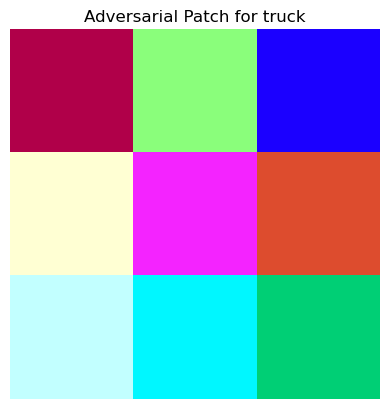

In [10]:
visualize_patch(patch, title=f"Adversarial Patch for {class_names[target_class]}")

/var/folders/2j/k_c_x4ps7n352tzdqvckkvb80000gn/T/ipykernel_38233/2913471911.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  patch = torch.load(patch_filename).to(device)

Targeted Attack Success Rate (Class 7): 8.98%


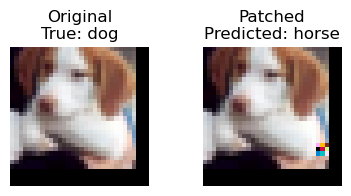

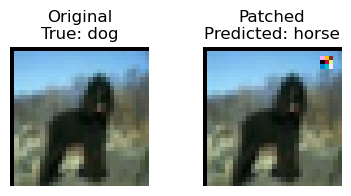

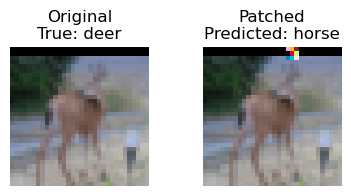

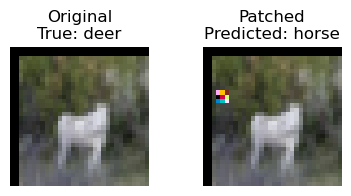

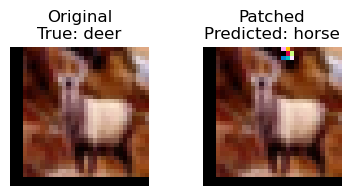

Targeted Attack Success Rate (Class 8): 10.14%


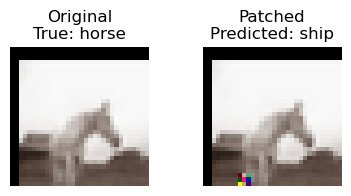

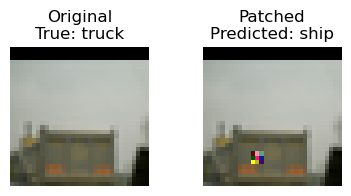

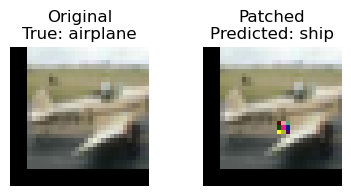

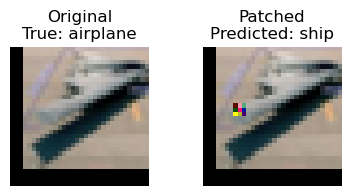

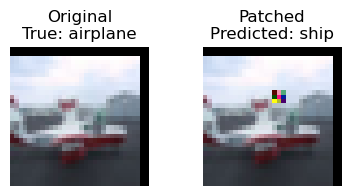

Targeted Attack Success Rate (Class 9): 10.79%


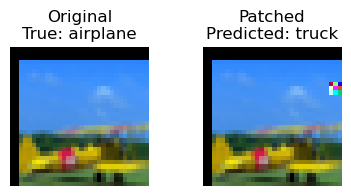

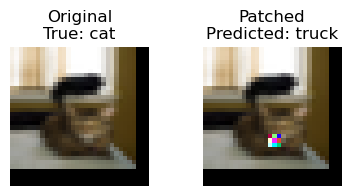

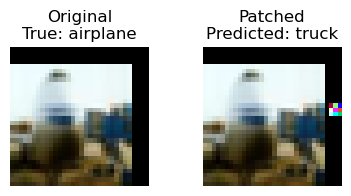

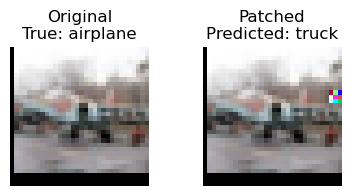

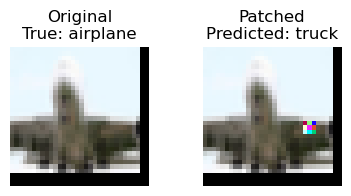

In [14]:
for target_class in target_classes:
    patch_filename = (
        f"adversarial_patch_{class_names[target_class]}_{patch_size}_baseline.pth"
    )

    patch = torch.load(patch_filename).to(device)

    evaluate_patch(model, patch, testloader, target_class=target_class)

    # Visualize misclassified patched images
    visualize_misclassified_patched_images(
        model=model,
        patch=patch,
        dataloader=testloader,
        target_class=target_class,
        num_images=5,  # Number of examples to visualize
    )

### 5 by 5

In [15]:
model = models.resnet18(pretrained=False)
num_classes = 10
model.fc = nn.Linear(model.fc.in_features, num_classes)

model = model.to(device)

checkpoint = torch.load("cifar_resnet18_pretrained_Jiwon.pth", map_location=device)
model.load_state_dict(checkpoint)

/var/folders/2j/k_c_x4ps7n352tzdqvckkvb80000gn/T/ipykernel_38233/2803613433.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("cifar_resnet18_pretr

<All keys matched successfully>

In [16]:
patch_size = (5, 5)
for target_class in target_classes:
    print(
        f"\n--- Training Patch for Target Class: {class_names[target_class]} ({target_class}) ---"
    )
    patch = create_patch(patch_size)

    train_adversarial_patch(
        model=model,
        patch=patch,
        dataloader=trainloader,
        target_class=target_class,
        num_epochs=20,
        lr=0.0001,
    )

    patch_filename = (
        f"adversarial_patch_{class_names[target_class]}_{patch_size}_baseline.pth"
    )
    torch.save(patch.detach().cpu(), patch_filename)
    print(f"Saved patch to {patch_filename}")

    print(
        f"--- Evaluating Patch for Target Class: {class_names[target_class]} ({target_class}) ---"
    )
    asr = evaluate_patch(
        model=model, patch=patch, dataloader=testloader, target_class=target_class
    )


--- Training Patch for Target Class: horse (7) ---
Epoch 1/20, Loss: 8.2072
Epoch 2/20, Loss: 8.2088
Epoch 3/20, Loss: 8.2008
Epoch 4/20, Loss: 8.2021
Epoch 5/20, Loss: 8.1920
Epoch 6/20, Loss: 8.1932
Epoch 7/20, Loss: 8.1927
Epoch 8/20, Loss: 8.1861
Epoch 9/20, Loss: 8.1903
Epoch 10/20, Loss: 8.1933
Epoch 11/20, Loss: 8.1790
Epoch 12/20, Loss: 8.1664
Epoch 13/20, Loss: 8.1574
Epoch 14/20, Loss: 8.1666
Epoch 15/20, Loss: 8.1687
Epoch 16/20, Loss: 8.1569
Epoch 17/20, Loss: 8.1671
Epoch 18/20, Loss: 8.1549
Epoch 19/20, Loss: 8.1517
Epoch 20/20, Loss: 8.1398
Saved patch to adversarial_patch_horse_(5, 5)_baseline.pth
--- Evaluating Patch for Target Class: horse (7) ---
Targeted Attack Success Rate (Class 7): 10.04%

--- Training Patch for Target Class: ship (8) ---
Epoch 1/20, Loss: 8.3357
Epoch 2/20, Loss: 8.3292
Epoch 3/20, Loss: 8.3290
Epoch 4/20, Loss: 8.3317
Epoch 5/20, Loss: 8.3195
Epoch 6/20, Loss: 8.3142
Epoch 7/20, Loss: 8.3025
Epoch 8/20, Loss: 8.3004
Epoch 9/20, Loss: 8.3100
Ep

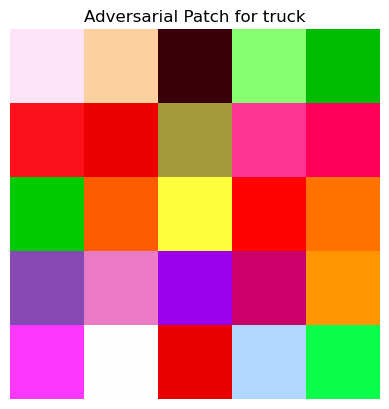

/var/folders/2j/k_c_x4ps7n352tzdqvckkvb80000gn/T/ipykernel_38233/692083658.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  patch = torch.load(patch_filename).to(device)


Targeted Attack Success Rate (Class 7): 9.17%


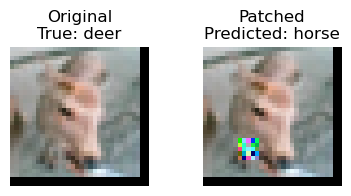

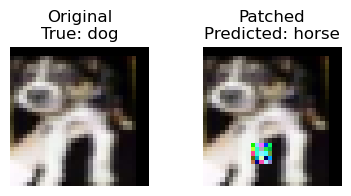

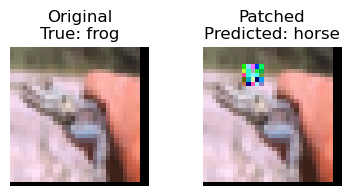

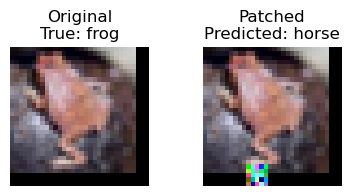

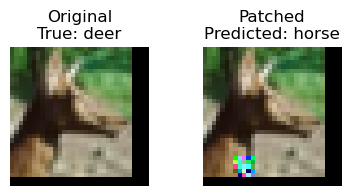

Targeted Attack Success Rate (Class 8): 9.87%


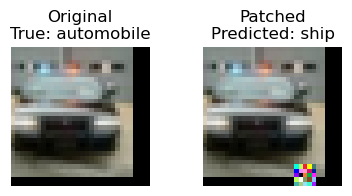

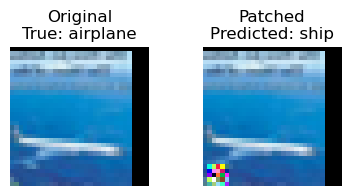

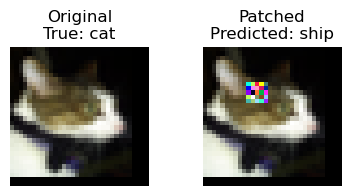

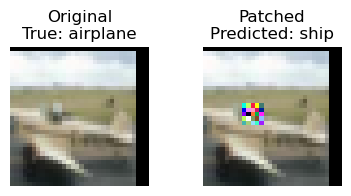

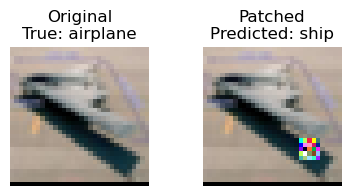

Targeted Attack Success Rate (Class 9): 11.06%


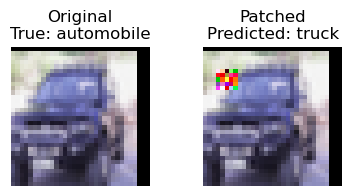

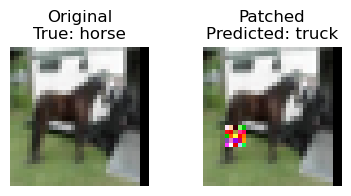

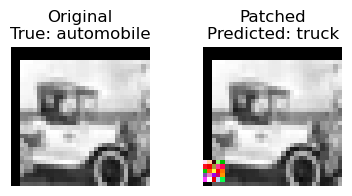

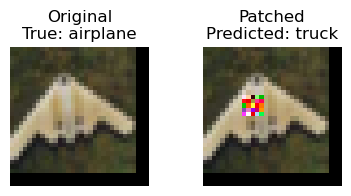

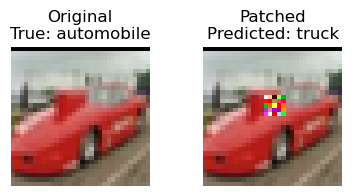

In [17]:
visualize_patch(patch, title=f"Adversarial Patch for {class_names[target_class]}")

for target_class in target_classes:
    patch_filename = (
        f"adversarial_patch_{class_names[target_class]}_{patch_size}_baseline.pth"
    )

    patch = torch.load(patch_filename).to(device)

    evaluate_patch(model, patch, testloader, target_class=target_class)

    # Visualize misclassified patched images
    visualize_misclassified_patched_images(
        model=model,
        patch=patch,
        dataloader=testloader,
        target_class=target_class,
        num_images=5,  # Number of examples to visualize
    )

### 7 by 7

In [18]:
model = models.resnet18(pretrained=False)
num_classes = 10
model.fc = nn.Linear(model.fc.in_features, num_classes)

model = model.to(device)

checkpoint = torch.load("cifar_resnet18_pretrained_Jiwon.pth", map_location=device)
model.load_state_dict(checkpoint)

/var/folders/2j/k_c_x4ps7n352tzdqvckkvb80000gn/T/ipykernel_38233/2803613433.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("cifar_resnet18_pretr

<All keys matched successfully>

In [19]:
patch_size = (7, 7)
for target_class in target_classes:
    print(
        f"\n--- Training Patch for Target Class: {class_names[target_class]} ({target_class}) ---"
    )
    patch = create_patch(patch_size)

    train_adversarial_patch(
        model=model,
        patch=patch,
        dataloader=trainloader,
        target_class=target_class,
        num_epochs=20,
        lr=0.0001,
    )

    patch_filename = (
        f"adversarial_patch_{class_names[target_class]}_{patch_size}_baseline.pth"
    )
    torch.save(patch.detach().cpu(), patch_filename)
    print(f"Saved patch to {patch_filename}")

    print(
        f"--- Evaluating Patch for Target Class: {class_names[target_class]} ({target_class}) ---"
    )
    asr = evaluate_patch(
        model=model, patch=patch, dataloader=testloader, target_class=target_class
    )


--- Training Patch for Target Class: horse (7) ---
Epoch 1/20, Loss: 8.0155
Epoch 2/20, Loss: 8.0013
Epoch 3/20, Loss: 8.0024
Epoch 4/20, Loss: 7.9936
Epoch 5/20, Loss: 7.9971
Epoch 6/20, Loss: 8.0178
Epoch 7/20, Loss: 7.9816
Epoch 8/20, Loss: 7.9807
Epoch 9/20, Loss: 7.9639
Epoch 10/20, Loss: 7.9730
Epoch 11/20, Loss: 7.9922
Epoch 12/20, Loss: 7.9791
Epoch 13/20, Loss: 7.9664
Epoch 14/20, Loss: 7.9821
Epoch 15/20, Loss: 7.9504
Epoch 16/20, Loss: 7.9514
Epoch 17/20, Loss: 7.9739
Epoch 18/20, Loss: 7.9700
Epoch 19/20, Loss: 7.9595
Epoch 20/20, Loss: 7.9457
Saved patch to adversarial_patch_horse_(7, 7)_baseline.pth
--- Evaluating Patch for Target Class: horse (7) ---
Targeted Attack Success Rate (Class 7): 9.00%

--- Training Patch for Target Class: ship (8) ---
Epoch 1/20, Loss: 8.1388
Epoch 2/20, Loss: 8.1264
Epoch 3/20, Loss: 8.1374
Epoch 4/20, Loss: 8.1315
Epoch 5/20, Loss: 8.1349
Epoch 6/20, Loss: 8.1083
Epoch 7/20, Loss: 8.1124
Epoch 8/20, Loss: 8.0978
Epoch 9/20, Loss: 8.1088
Epo

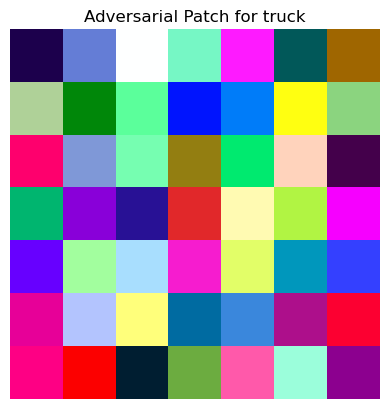

/var/folders/2j/k_c_x4ps7n352tzdqvckkvb80000gn/T/ipykernel_38233/692083658.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  patch = torch.load(patch_filename).to(device)


Targeted Attack Success Rate (Class 7): 9.60%


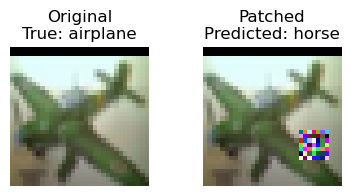

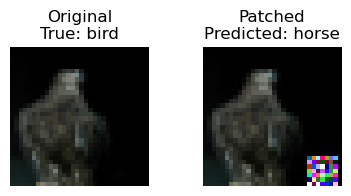

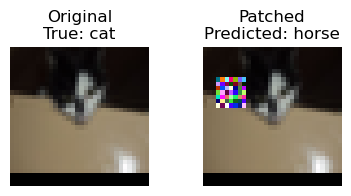

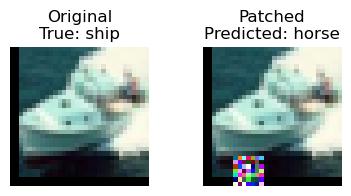

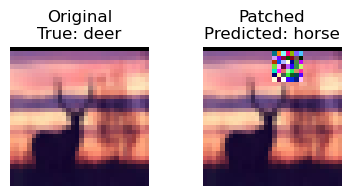

Targeted Attack Success Rate (Class 8): 10.01%


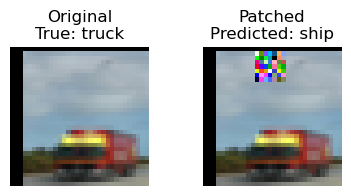

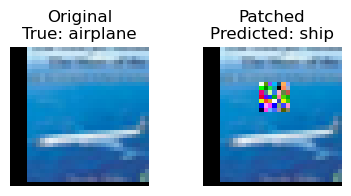

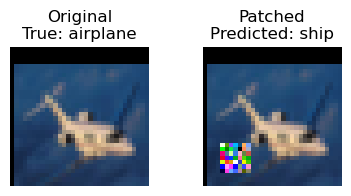

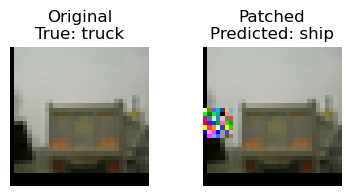

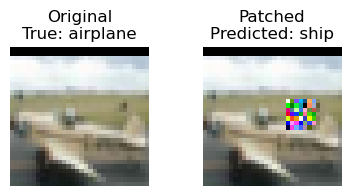

Targeted Attack Success Rate (Class 9): 10.37%


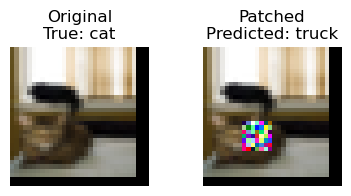

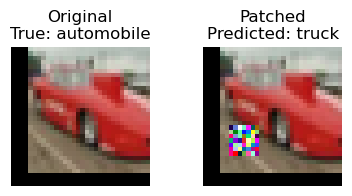

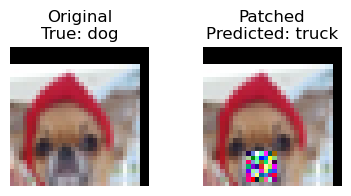

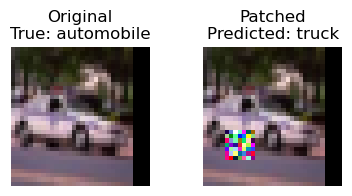

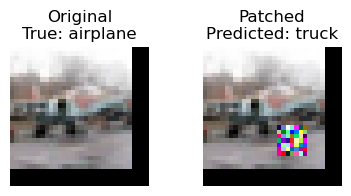

In [20]:
visualize_patch(patch, title=f"Adversarial Patch for {class_names[target_class]}")

for target_class in target_classes:
    patch_filename = (
        f"adversarial_patch_{class_names[target_class]}_{patch_size}_baseline.pth"
    )

    patch = torch.load(patch_filename).to(device)

    evaluate_patch(model, patch, testloader, target_class=target_class)

    # Visualize misclassified patched images
    visualize_misclassified_patched_images(
        model=model,
        patch=patch,
        dataloader=testloader,
        target_class=target_class,
        num_images=5,  # Number of examples to visualize
    )

### 16 by 16

In [21]:
model = models.resnet18(pretrained=False)
num_classes = 10
model.fc = nn.Linear(model.fc.in_features, num_classes)

model = model.to(device)

checkpoint = torch.load("cifar_resnet18_pretrained_Jiwon.pth", map_location=device)
model.load_state_dict(checkpoint)

/var/folders/2j/k_c_x4ps7n352tzdqvckkvb80000gn/T/ipykernel_38233/2803613433.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("cifar_resnet18_pretr

<All keys matched successfully>

In [22]:
patch_size = (16, 16)
for target_class in target_classes:
    print(
        f"\n--- Training Patch for Target Class: {class_names[target_class]} ({target_class}) ---"
    )
    patch = create_patch(patch_size)

    train_adversarial_patch(
        model=model,
        patch=patch,
        dataloader=trainloader,
        target_class=target_class,
        num_epochs=20,
        lr=0.0001,
    )

    patch_filename = (
        f"adversarial_patch_{class_names[target_class]}_{patch_size}_baseline.pth"
    )
    torch.save(patch.detach().cpu(), patch_filename)
    print(f"Saved patch to {patch_filename}")

    print(
        f"--- Evaluating Patch for Target Class: {class_names[target_class]} ({target_class}) ---"
    )
    asr = evaluate_patch(
        model=model, patch=patch, dataloader=testloader, target_class=target_class
    )


--- Training Patch for Target Class: horse (7) ---
Epoch 1/20, Loss: 7.2556
Epoch 2/20, Loss: 7.2644
Epoch 3/20, Loss: 7.2441
Epoch 4/20, Loss: 7.2358
Epoch 5/20, Loss: 7.2538
Epoch 6/20, Loss: 7.2350
Epoch 7/20, Loss: 7.2443
Epoch 8/20, Loss: 7.2580
Epoch 9/20, Loss: 7.2345
Epoch 10/20, Loss: 7.2499
Epoch 11/20, Loss: 7.2561
Epoch 12/20, Loss: 7.2317
Epoch 13/20, Loss: 7.2273
Epoch 14/20, Loss: 7.2106
Epoch 15/20, Loss: 7.2430
Epoch 16/20, Loss: 7.2235
Epoch 17/20, Loss: 7.2403
Epoch 18/20, Loss: 7.2270
Epoch 19/20, Loss: 7.2331
Epoch 20/20, Loss: 7.2257
Saved patch to adversarial_patch_horse_(16, 16)_baseline.pth
--- Evaluating Patch for Target Class: horse (7) ---
Targeted Attack Success Rate (Class 7): 9.03%

--- Training Patch for Target Class: ship (8) ---
Epoch 1/20, Loss: 7.3771
Epoch 2/20, Loss: 7.3485
Epoch 3/20, Loss: 7.3621
Epoch 4/20, Loss: 7.3488
Epoch 5/20, Loss: 7.3497
Epoch 6/20, Loss: 7.3511
Epoch 7/20, Loss: 7.3606
Epoch 8/20, Loss: 7.3356
Epoch 9/20, Loss: 7.3491
E

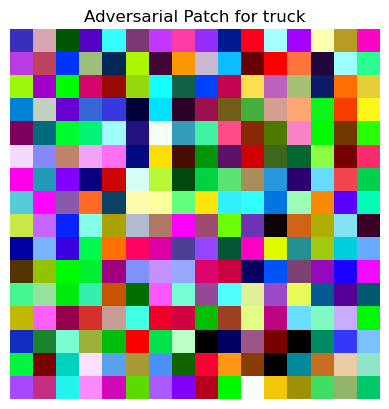

/var/folders/2j/k_c_x4ps7n352tzdqvckkvb80000gn/T/ipykernel_38233/692083658.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  patch = torch.load(patch_filename).to(device)


Targeted Attack Success Rate (Class 7): 8.50%


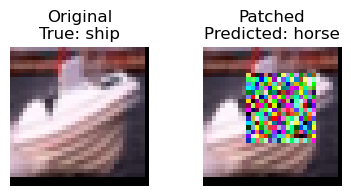

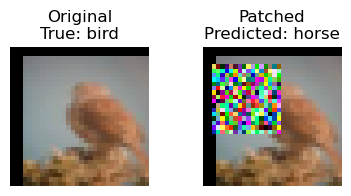

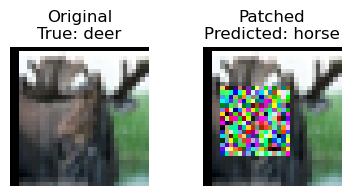

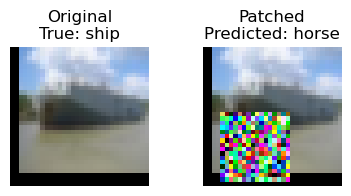

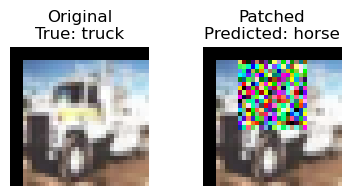

Targeted Attack Success Rate (Class 8): 14.20%


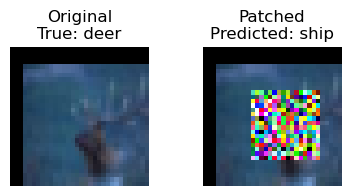

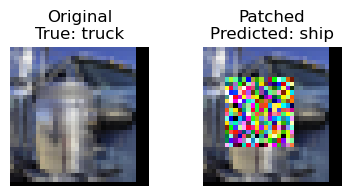

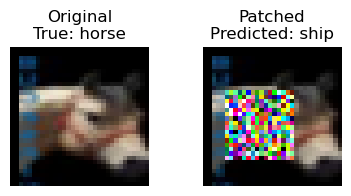

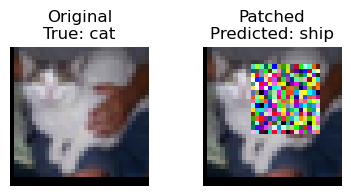

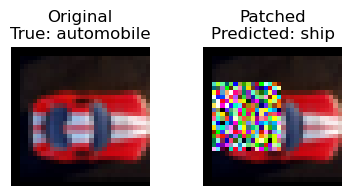

Targeted Attack Success Rate (Class 9): 12.33%


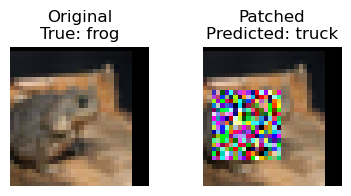

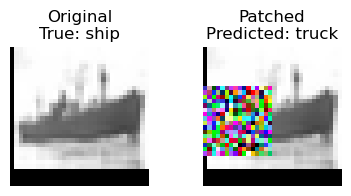

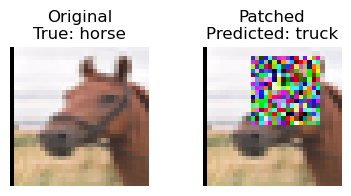

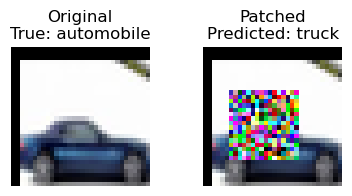

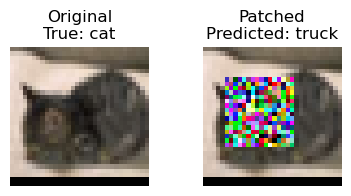

In [23]:
visualize_patch(patch, title=f"Adversarial Patch for {class_names[target_class]}")

for target_class in target_classes:
    patch_filename = (
        f"adversarial_patch_{class_names[target_class]}_{patch_size}_baseline.pth"
    )

    patch = torch.load(patch_filename).to(device)

    evaluate_patch(model, patch, testloader, target_class=target_class)

    # Visualize misclassified patched images
    visualize_misclassified_patched_images(
        model=model,
        patch=patch,
        dataloader=testloader,
        target_class=target_class,
        num_images=5,  # Number of examples to visualize
    )

### Results

#### class_names = {7: "horse", 8: "ship", 9: "truck"}

#### 3 by 3

Targeted Attack Success Rate (Class 7): 8.98%

Targeted Attack Success Rate (Class 8): 10.14%

Targeted Attack Success Rate (Class 9): 10.79%

#### 5 by 5

Targeted Attack Success Rate (Class 7): 9.17%

Targeted Attack Success Rate (Class 8): 9.87%

Targeted Attack Success Rate (Class 9): 11.06%

#### 7 by 7

Targeted Attack Success Rate (Class 7): 9.60%

Targeted Attack Success Rate (Class 8): 10.01%

Targeted Attack Success Rate (Class 9): 10.37%

#### 16 by 16

Targeted Attack Success Rate (Class 7): 8.50%

Targeted Attack Success Rate (Class 8): 14.20%

Targeted Attack Success Rate (Class 9): 12.33%